In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
inv = np.linalg.inv
import bio_lda.lda as lda
import bio_lda.util as util

In [2]:
samples = int(10e3) # Number of samples in dataset
d = 50 # Dimensionality of Data
proportions = [0.5,0.5] # Proportion of samples in classes
X, y, m1, m2, cov = util.generate_dataset(samples, d, proportions)



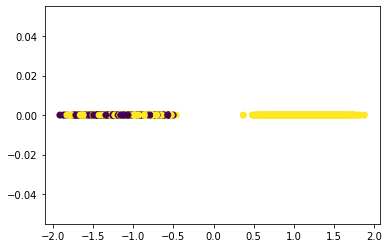

0.7


In [3]:
y_, true_LDA_score = util.scikit_LDA(X, y)
plt.scatter(y_,np.zeros(y_.shape), c = y)
plt.show()
print(true_LDA_score)


In [4]:
err, metric, optimal = util.run_offline(X, y, m1, m2, cov, true_LDA_score, epochs=5000)

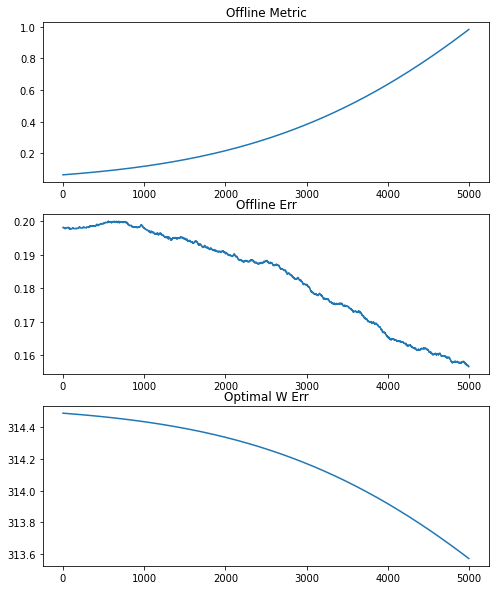

In [5]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()

In [6]:
err, metric, optimal = util.run_online(X, y, m1, m2, cov,  true_LDA_score, epochs=50)

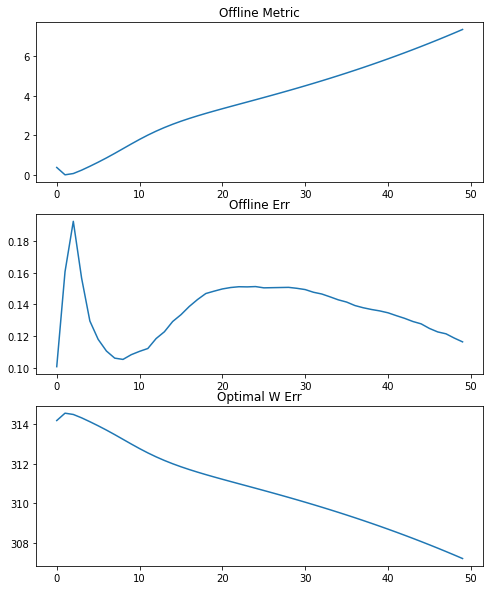

In [7]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()